In [1]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.4.0
appdirs                      1.4.4
asttokens                    2.2.1
astunparse                   1.6.3
audioread                    3.0.0
backcall                     0.2.0
cachetools                   5.2.1
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.2
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.5
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
entrypoints                  0.4
etils                        1.0.0
executing                    1.2.0
flatbuffers                  23.1.21
fonttools                    4.38.0
gast                         0.5.3
google-auth                  2.1

You should consider upgrading via the 'C:\Deep Learning Projects\AngCommands\env_angmincommands\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 tensorflow-io==0.25.0 tensorflow_datasets matplotlib

You should consider upgrading via the 'C:\Deep Learning Projects\AngCommands\env_angmincommands\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import pathlib

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf 
import tensorflow_io as tfio

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import librosa
import librosa.display
import IPython


SR specifies the sample rate of the audio data in Hz.

DURATION is the duration of the audio clip in seconds.

PRE_EMPHASIS is the pre-emphasis coefficient used to apply a high-pass filter to the audio signal.

N_MFCC is the number of Mel-frequency cepstral coefficients (MFCCs) to compute.

N_FFT is the number of points to use in the discrete Fourier transform (DFT).

HOP_LENGTH is the number of samples to hop between successive windows.

N_MELS is the number of Mel frequency bins to use.

In [ ]:
SR = 16000
DURATION = 2.0
PRE_EMPHASIS = 0.97
N_MFCC = 13
N_FFT = 512
HOP_LENGTH = 160
N_MELS = 40

ZBUDOWANIE ZESTAWU TRENINGOWEGO

In [2]:
def get_label(file_path):
    parts = tf.strings.split( input=file_path, sep=os.path.sep )
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

In [3]:
def load_and_decode_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

In [4]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    waveform = load_and_decode_audio(file_path)
    return waveform, label

In [5]:
def get_spectrogram(waveform):
    
    n_fft = 1028#2048
    hop_length = 32#512
    n_mels = 128
    
    frame_rate = 16000
    f_min = 0
    f_max = 4000

    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(waveform, nfft=n_fft, window=n_fft, stride=n_mels)
      
    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=frame_rate, mels=n_mels, fmin=f_min, fmax=f_max)    
    
    # Convert to db scale mel-spectrogram
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    dbscale_mel_spectrogram = dbscale_mel_spectrogram[..., tf.newaxis]
    #    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return dbscale_mel_spectrogram

In [6]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = spectrogram.T + np.finfo(float).eps
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [7]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [8]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    
    output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
    
    return output_ds

In [9]:
DATASET_PATH = 'data_pol'
data_dir = pathlib.Path(DATASET_PATH)

ZAŁADOWANIE KOMEDN

In [10]:
filenames = tf.io.gfile.glob(str(data_dir)+'/*/*.wav')


files_total_number = len(filenames)
print('Liczba wszystkich próbek : ', files_total_number)

commands = np.array(tf.io.gfile.listdir(str(data_dir)))

for command in commands:
    print(command, len(tf.io.gfile.glob( str(os.path.join(data_dir,command)) + '/*.wav')))
    

lengths = []
for file_name in filenames:
    wav = load_and_decode_audio(file_name)
    lengths.append(len(wav))

array = np.array(lengths)
print(array.min())
print(array.max())
print(array.mean())


Liczba wszystkich próbek :  4950
00-odrzuc_bron 990
01-obroc_sie 990
02-na_kolana 990
03-gleba 990
04-rece_na_glowe 990
32000
32000
32000.0


PODZIAŁ NA ZESTAWY

In [11]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

filenames = tf.random.shuffle(filenames)

train_num = 0.60
val_num = 0.25
test_num = 0.15

train_files = filenames[:int(files_total_number*train_num)]
val_files = filenames[int(files_total_number*train_num) : int(files_total_number*train_num) + int(files_total_number*val_num)]
test_files = filenames[int(files_total_number*train_num) + int(files_total_number*val_num):]

print('Zestaw uczący : ', len(train_files))

com = np.zeros(5)
for i,(command) in enumerate(commands):
    for file in train_files:
        if get_label(file) == command:
            com[i] += 1
    print(com[i])
    
print('Zestaw walidacyjny : ', len(val_files))

com = np.zeros(5)
for i,(command) in enumerate(commands):
    for file in val_files:
        if get_label(file) == command:
            com[i] += 1
    print(com[i])
    
print('Zestaw testowy : ', len(test_files))

com = np.zeros(5)
for i,(command) in enumerate(commands):
    for file in test_files:
        if get_label(file) == command:
            com[i] += 1
    print(com[i])


Zestaw uczący :  2970
610.0
602.0
572.0
575.0
611.0
Zestaw walidacyjny :  1237
250.0
252.0
243.0
252.0
240.0
Zestaw testowy :  743
130.0
136.0
175.0
163.0
139.0


PRZYGOTOWANIE DATASETÓW

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

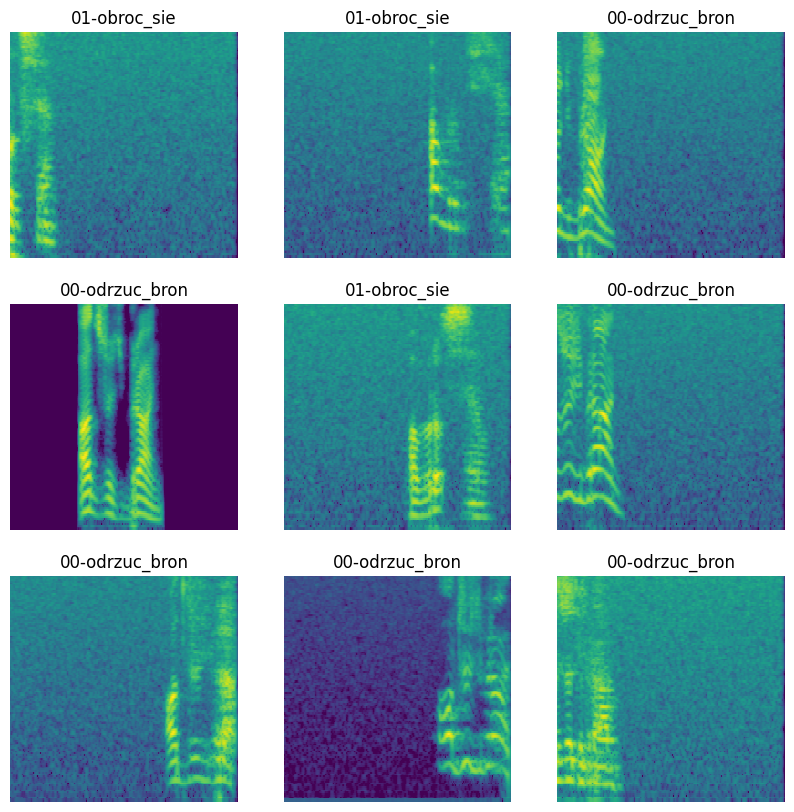

In [133]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')
plt.savefig("1028-16-4.png")
plt.show()

In [13]:
batch_size = 32

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

#Dataset.cache i Dataset.prefetch , aby zmniejszyć opóźnienie odczytu podczas uczenia modelu:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [14]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (250, 128, 1)


In [15]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [45]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 688, 126, 16)      160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 344, 63, 16)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 342, 61, 32)       4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 171, 30, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 169, 28, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 84, 14, 64)      

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)


In [17]:
EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
93/93 [==============================] - 206s 2s/step - loss: 1.1691 - accuracy: 0.5401 - val_loss: 0.6166 - val_accuracy: 0.8036
Epoch 2/30
93/93 [==============================] - 9s 102ms/step - loss: 0.4992 - accuracy: 0.8343 - val_loss: 0.3545 - val_accuracy: 0.8868
Epoch 3/30
93/93 [==============================] - 9s 100ms/step - loss: 0.2999 - accuracy: 0.8960 - val_loss: 0.2333 - val_accuracy: 0.9329
Epoch 4/30
93/93 [==============================] - 9s 102ms/step - loss: 0.2039 - accuracy: 0.9367 - val_loss: 0.1950 - val_accuracy: 0.9426
Epoch 5/30
93/93 [==============================] - 10s 104ms/step - loss: 0.1501 - accuracy: 0.9455 - val_loss: 0.1691 - val_accuracy: 0.9539
Epoch 6/30
93/93 [==============================] - 9s 101ms/step - loss: 0.1303 - accuracy: 0.9549 - val_loss: 0.1517 - val_accuracy: 0.9572
Epoch 7/30
93/93 [==============================] - 9s 102ms/step - loss: 0.0987 - accuracy: 0.9673 - val_loss: 0.1335 - val_accuracy: 0.9677
Epoch 

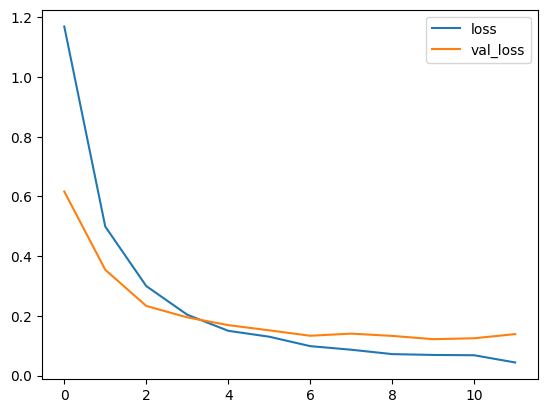

In [18]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

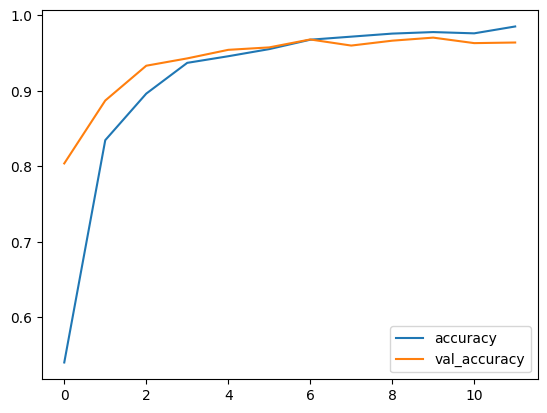

In [19]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [20]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [21]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 97%


In [22]:
model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model\assets


In [23]:
loaded_model = models.load_model('saved_model')

In [24]:
filenames2 = tf.io.gfile.glob('check'+'/*/*.wav')
seed = 50
tf.random.set_seed(seed)
np.random.seed(seed)
filenames2 = tf.random.shuffle(filenames2)
print(len(filenames2))

200


In [25]:
test_ds2 = preprocess_dataset(filenames2)

test_audio = []
test_labels = []

for audio, label in test_ds2:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 55%


tf.Tensor([[1.3451703e-06 8.8506401e-02 2.7235663e-02 1.2515931e-03 8.8300502e-01]], shape=(1, 5), dtype=float32)


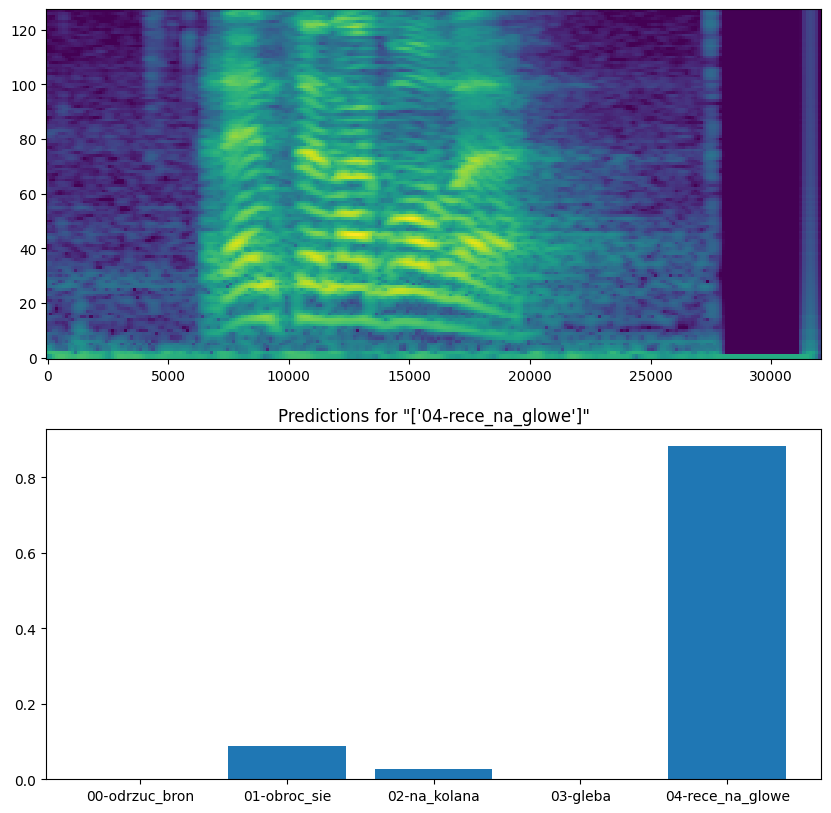

In [49]:
fig, axes = plt.subplots(2, figsize=(10, 10))

for spectrogram, label in test_ds2.take(1).batch(1):   

    plot_spectrogram(spectrogram[0].numpy(), axes[0])
    
    prediction = model(spectrogram)
    print(prediction)
    plt.bar(commands, prediction[0])
    plt.title(f'Predictions for "{commands[label]}"')    
    plt.show()
